In [1]:
import numpy as np
import pandas as pd
import os
import multiprocessing as mul
from multiprocessing import Process
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize

In [2]:
####
#### IMPORTING AND SPLITTING ICDATA $$$


path = "/media/darkwake/VIB2/Project-IceCube/icecube_10year_ps/events"
filenames = ["IC40_exp.csv", "IC59_exp.csv","IC79_exp.csv", "IC86_I_exp.csv", "IC86_II_exp.csv",
"IC86_III_exp.csv", "IC86_IV_exp.csv", "IC86_V_exp.csv", "IC86_VI_exp.csv", "IC86_VII_exp.csv"]
file = filenames[0]
f = open(os.path.join(path, file), 'r')
lines = f.readlines()
column=lines[0].split()
column.pop(0)
content = []
for file in filenames:
    f = open(os.path.join(path, file), 'r')
    lines = f.readlines()
    for line in lines[1:]:
        content.append(line.split())
    f.close()
icdata = pd.DataFrame(content, columns=column)
icdata['log10(E/GeV)'] = [float(i) for i in icdata['log10(E/GeV)']]

#icdata = icdata.sort_values('log10(E/GeV)')
#icdata = icdata.reset_index()
#icdata = icdata.drop('index', axis=1)
icdata2 = icdata[icdata['log10(E/GeV)'] > 5]
icdata2 = icdata2.reset_index()
icdata2 = icdata2.drop('index', axis=1)
icdata2

#IMPORTING MSPDATA
f = open("/media/darkwake/VIB2/Project-IceCube/10milsecpsr.txt", 'r')
lines = f.readlines()

content=[]
column=lines[3].split()
for line in lines[:]:
    content.append(line.split())
    #the INITAL DATABASE IS CLUTTERED SO WE REMOVE THE NULL COLUMNS AND OTHER CLUTTER
mspdata = pd.DataFrame(content).drop(range(0,6)).dropna().drop([2,6,8,10,11,13,14], axis=1)
f.close()
line = []
lines = []

mspdata.columns = column
column = []
content=[]
mspdata = mspdata.sort_values('DECJD')
mspdata.dropna(inplace=True)
mspdata = mspdata.reset_index()
mspdata = mspdata.drop(["index", "#"], axis=1)

icdata2

mspdata

In [3]:
#icdata2 = nu_10gev(import_icdata())
#mspdata = import_psrdata()
msra = [float(i) for i in mspdata['RAJD']]
msdec = [float(i) for i in mspdata['DECJD']]
icra = [float(i) for i in icdata2['RA[deg]']]
icdec = [float(i) for i in icdata2['Dec[deg]']]
icang = [float(i) for i in icdata2['AngErr[deg]']]
p = len(msra)
lg = len(icra) // p + 1
cut = 20

In [4]:
def hvovec(lon1, lat1, lon2, lat2):

    #Convert decimal degrees to Radians:
    lon1 = np.deg2rad(lon1)
    lat1 = np.deg2rad(lat1)
    lon2 = np.deg2rad(lon2)
    lat2 = np.deg2rad(lat2)

    #Implementing Haversine Formula: 
    dlon = np.subtract(lon2, lon1)
    #dlat = np.subtract(lat2, lat1)

    a = np.add(np.multiply(np.sin(lat1), np.sin(lat2)), np.multiply(np.multiply(np.cos(lat1), np.cos(lat2)), np.cos(dlon)))

    return np.abs(np.rad2deg(np.arccos(a)))

In [5]:
cut = 180

In [6]:
def angfinder(b):
    ang = []
    for a in range(lg):
        
        if a != lg - 1:
        #try:
            ilo = icra[a*p:a*p + p]
            ila = icdec[a*p:a*p + p]
            lo = msra[b] * np.ones(p)
            la = msdec[b] * np.ones(p)
            temp = hvovec(ilo, ila, lo, la)
            for tt in range(len(temp)):
                if temp[tt] > cut:
                    temp[tt] = -1
            ang.extend(temp)
        else:
        #except:
            ilo = icra[a*p:]
            ila = icdec[a*p:]
            ext = len(ilo)
            lo = msra[b] * np.ones(ext)
            la = msdec[b] * np.ones(ext)
            temp = hvovec(ilo, ila, lo, la)
            #ang.extend(hvovec(ilo, ila, lo, la))
            for tt in range(len(temp)):
                if temp[tt] > cut:
                    temp[tt] = -1
            ang.extend(temp)
            
        
    return ang

In [7]:

#S_ij for ith neutrino and jth pulsar IS WRONG
#EDIT 04102022 - 11.28 - S_ij is for i^th pulsar and j^th neutrino and summed over all NEUTRINOS IS WRONG
#EDIT 06102022 - 16.52 - Si is for i^th neutrino and s^th pulsar as in \theta_s
def S_ij(i):### $P_i[a] = \dfrac{ns[a]}{N} S[a] + \left(1 - \dfrac{ns[a]}{N}\right)B[a]$ if ns 
                                                 #OR
    arr = []
    for j in range(0,len(icdata2)):
        ang = aang[i][j]
        if ang != -1:
            if True and ang < cut:
                sg = np.deg2rad(icang[j]) ** 2
                ang = np.deg2rad(ang) ** 2
                arr.append(np.exp(-1 * ang / (2 * sg)) / (2 * np.pi * sg))
        #return
        #else:
            #arr.append(0)
        #return -1
    
    return arr
def sij():
    pool = mul.Pool()
    op_async = pool.map_async(S_ij, range(0,p))
    si = op_async.get()
    pool = []
    op_async = []
    return si

#### CUT = 

In [8]:
pool = mul.Pool()
op_async = pool.map_async(angfinder, range(0,p))
aang = op_async.get()
op_async = []
pool = []

In [9]:

S = sij()

In [10]:
#N != len(icdata2)
def nsang(aang):
    Ns = []
    for i in aang:
        count = 0
        for j in i:
            if j != -1:
                if j < cut:
                    count += 1
        Ns.append(count)
    Ns = np.array(Ns)
    return Ns
Ns = nsang(aang)
#Ns = len(icdata2)*np.ones(len(S))
    

In [11]:
lt = 3
def bg(i):
    #Calculating total no of neutrino events within delta +/- 6 of ith PULSAR (not neutrino)
    count = 0
    
    '''for j in icdec:
        if abs(msdec[i] - j) <= 6:
            count+=1 '''
    count = np.count_nonzero(np.abs(np.subtract(msdec[i],icdec))<lt)
    #calculating solid angle with lt deg cone
    num = (np.pi * np.deg2rad(lt))**2
    sang = 2 * np.pi * (np.sin(np.deg2rad(msdec[i] + lt)) - np.sin(np.deg2rad(msdec[i] - lt)))
    return num * count/sang

def Bi():
    pool = mul.Pool()
    op_async = pool.map_async(bg, range(0,p))
    return op_async.get()

B = np.array(Bi())

In [12]:
def Pr(x, Ns, S, B):
    nsN = x/Ns
    return np.add(np.multiply(nsN , S), np.multiply(np.subtract(1, nsN), B))

In [13]:
TS = lambda i, x: 2*np.sum(np.log(Pr(x,  Ns[i], S[i], B[i])/B[i]))

In [14]:
def TSmax(i):
    #returns the TSmax for i^th GRB
    #a = []
    #for j in range(1000):
        #a.append(TS(i,j))
         
    #init_guess = a.index(max(a))
    nll = lambda x: -TS(i,x)
    soln = minimize(nll, 3 ,bounds=((0,None),))
    ns = float(soln.x)
    #print(f"Pulsar {i} done")
    return ns


In [15]:
pool = mul.Pool()
op_async = pool.map_async(TSmax, range(0,p))
ns = op_async.get()
op_async = []
pool = []
##   ns.append(TSmax(i))

/tmp/ipykernel_65240/34067360.py:1: RuntimeWarning: divide by zero encountered in divide
  TS = lambda i, x: 2*np.sum(np.log(Pr(x,  Ns[i], S[i], B[i])/B[i]))
/tmp/ipykernel_65240/34067360.py:1: RuntimeWarning: invalid value encountered in divide
  TS = lambda i, x: 2*np.sum(np.log(Pr(x,  Ns[i], S[i], B[i])/B[i]))
/tmp/ipykernel_65240/34067360.py:1: RuntimeWarning: divide by zero encountered in divide
  TS = lambda i, x: 2*np.sum(np.log(Pr(x,  Ns[i], S[i], B[i])/B[i]))
/tmp/ipykernel_65240/34067360.py:1: RuntimeWarning: invalid value encountered in divide
  TS = lambda i, x: 2*np.sum(np.log(Pr(x,  Ns[i], S[i], B[i])/B[i]))


In [16]:
tns = np.array([TS(i,ns[i]) for i in range(p)])

/tmp/ipykernel_65240/34067360.py:1: RuntimeWarning: divide by zero encountered in divide
  TS = lambda i, x: 2*np.sum(np.log(Pr(x,  Ns[i], S[i], B[i])/B[i]))
/tmp/ipykernel_65240/34067360.py:1: RuntimeWarning: invalid value encountered in divide
  TS = lambda i, x: 2*np.sum(np.log(Pr(x,  Ns[i], S[i], B[i])/B[i]))


In [17]:
c = []
d = []
for i in ns:
    if i != 0:
        c.append(ns.index(i))
        d.append(TS(ns.index(i), i))
        #print(TS(ns.index(i), i))

/tmp/ipykernel_65240/34067360.py:1: RuntimeWarning: divide by zero encountered in divide
  TS = lambda i, x: 2*np.sum(np.log(Pr(x,  Ns[i], S[i], B[i])/B[i]))
/tmp/ipykernel_65240/34067360.py:1: RuntimeWarning: invalid value encountered in divide
  TS = lambda i, x: 2*np.sum(np.log(Pr(x,  Ns[i], S[i], B[i])/B[i]))


In [18]:
set(c)

{406}

In [19]:
len(c)

7

In [20]:
print("Pulsar\tns\tTSmax")
for i in range(len(c)):
    print(f"{c[i]}\t{ns[c[i]]}\t{d[i]}")

Pulsar	ns	TSmax
406	3.0	nan
406	3.0	nan
406	3.0	nan
406	3.0	nan
406	3.0	nan
406	3.0	nan
406	3.0	nan


TS(57, 45)

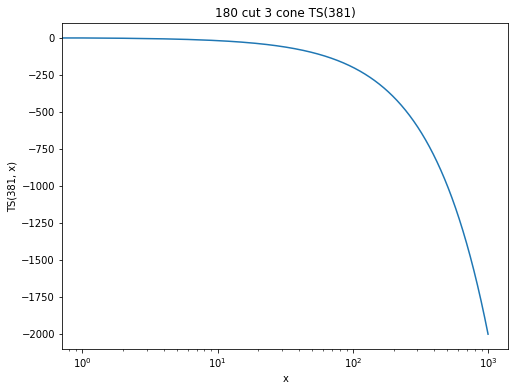

In [21]:
i = 381
n = np.array(range(0, 1000))
ts = [TS(i, x) for x in range(1000)]
plt.figure(figsize=(8,6))
plt.xscale('log')
plt.plot(n, ts)
plt.xlabel('x')
plt.ylabel(f'TS({i}, x)')
plt.title(f"{cut} cut {lt} cone TS({i})")
plt.savefig(f"{cut}cut{lt}cone-TS({i}).jpg")
plt.show()


In [22]:
psr = 381
nudata =  []
f = open(f"nnear_P{psr}_{cut}cut_{lt}cone.txt", 'w')
f.write("nura, nudec, angerr\n")
for j in aang[psr]:
    if j != -1:
        #nudata.append([icra[j], icdec[j], icang[j]])
        f.write(str([icra[aang[psr].index(j)], icdec[aang[psr].index(j)], icang[aang[psr].index(j)]]).replace('[', '').replace(']',''))
        f.write('\n')

    



KeyboardInterrupt: 

In [ ]:
[msra[381], msdec[381]]